# DA3-A3 
## Parker & Co. -1
Peter Szilvasi,
Máté Schieszler 

In [570]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import warnings

warnings.filterwarnings("ignore")

In [571]:
from py_helper_functions import *

In [572]:
# Read in the data offline
original_data = pd.read_csv('cs_bisnode_panel.csv')

In [573]:
# Read in the data online
#original_data = pd.read_csv('https://raw.githubusercontent.com/mateschieszler/DA3-A3/main/cs_bisnode_panel.csv')

In [574]:
# copy original so we don't have to reload it every time (it takes more than 10s)
data = original_data.copy()

In [575]:
# filter out ind2 != 26
data = data.loc[data['ind2'] == 26]
data['sales'].fillna(0, inplace=True)
data.shape

(14877, 48)

In [576]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [577]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in one year if there are sales in this year but no sales the next year
# Status_in_a_year: data.groupby('comp_id')['status_alive'].shift(-1)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [578]:
holdout_set = data.loc[(data['year'] == 2014) & (data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout_set))
print("Number of defaulted firms:", len(holdout_set[holdout_set['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout_set[holdout_set['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout_set['sales'].mean())
print("Minimum sales:", holdout_set['sales'].min())
print("Maximum sales:", holdout_set['sales'].max())

Total firms in holdout set: 1037
Number of defaulted firms: 56
Number of firms that stayed alive: 981
Average sales of the firms: 490202.21792682
Minimum sales: 1070.370361328125
Maximum sales: 9576485.0


In [579]:
data.shape

(21948, 50)

In [580]:
# with this -> data = working set
# data = data.drop(holdout_set.index)

## Handling Missing Values

In [581]:
# look at missing values
data.isna().sum()

year                        0
comp_id                     0
begin                    7071
end                      7071
COGS                    20093
amort                    7359
curr_assets              7076
curr_liab                7076
extra_exp                7941
extra_inc                7941
extra_profit_loss        7892
finished_prod           20125
fixed_assets             7076
inc_bef_tax              7304
intang_assets            7076
inventories              7076
liq_assets               7076
material_exp             7359
net_dom_sales           20093
net_exp_sales           20093
personnel_exp            7359
profit_loss_year         7664
sales                    7071
share_eq                 7076
subscribed_cap           7076
tang_assets              7125
wages                   20131
D                       21948
balsheet_flag            7071
balsheet_length          7071
balsheet_notfullyear     7071
founded_year             9715
exit_year               20546
ceo_count 

In [582]:
# Calculate percentage of missing values in each column of the original dataset
original_missing_percentage = (original_data.isnull().sum() / len(original_data)) * 100

# Calculate percentage of missing values in each column of the filtered dataset
filtered_missing_percentage = (data.isnull().sum() / len(data)) * 100

# Calculate percentage of missing values in each column of the filtered dataset
filtered_missing_percentage = (data.isnull().sum() / len(data)) * 100

# Combine the missing percentage information into a DataFrame for easier comparison
missing_info = pd.DataFrame({
    'Original Data Missing %': original_missing_percentage,
    'Filtered Data Missing %': filtered_missing_percentage
})

missing_info.sort_values(by='Filtered Data Missing %', ascending=False)

,Original Data Missing %,Filtered Data Missing %
D,100.000000,100.000000
exit_year,86.499276,93.612174
wages,93.752193,91.721341
finished_prod,93.925213,91.694004
COGS,93.656998,91.548205
net_exp_sales,93.656998,91.548205
net_dom_sales,93.656998,91.548205
exit_date,80.481466,91.037908
labor_avg,50.909394,69.687443
birth_year,38.848761,57.677237


Would it makes sense to examine all original data as it might have some additinal info which might uncover relations that are not present in our data?

In [583]:
# drop columns with over 12000 missing values
to_drop = ['D','exit_year','wages','finished_prod','COGS','net_exp_sales','net_dom_sales','exit_date']
data = data.drop(to_drop, axis=1)

In [584]:
# drop where industry is empty, itt nem tudom ezt kell e, vagy csak flageljük
data = data.dropna(subset="ind2")

In [585]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,labor_avg,status_alive,default
0,2005,6.538183e+06,2005-01-01,2005-12-31,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,Foreign,2630.0,26.0,2.0,2.0,East,1992-08-25,NaN,1,0
1,2005,6.934257e+06,2005-05-13,2005-12-31,803.703674,4648.147949,9311.111328,0.000000,0.000000,0.000000,...,NaN,2660.0,26.0,2.0,3.0,East,2005-04-26,NaN,1,1
2,2005,8.416055e+06,2005-01-01,2005-12-31,3155.555664,71070.367188,25514.814453,74.074074,0.000000,-74.074074,...,Domestic,2651.0,26.0,2.0,1.0,Central,1995-08-28,NaN,1,0
5,2005,1.242838e+07,2005-01-01,2005-12-31,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,Domestic,2660.0,26.0,2.0,2.0,Central,1991-06-27,NaN,1,0
7,2005,1.571155e+07,2005-01-01,2005-12-31,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,Domestic,2630.0,26.0,2.0,1.0,Central,2001-09-01,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21937,2016,4.580800e+11,2016-01-01,2016-12-31,3529.629639,125537.039062,0.000000,NaN,NaN,NaN,...,Domestic,2630.0,26.0,2.0,1.0,Central,1995-07-02,0.166667,1,0
21939,2016,4.591262e+11,2016-01-01,2016-12-31,4011.111084,58948.148438,30874.074219,NaN,NaN,NaN,...,Foreign,2611.0,26.0,2.0,3.0,East,1994-12-14,0.125000,1,0
21944,2016,4.610112e+11,2016-01-01,2016-12-31,148.148148,67448.148438,5059.259277,NaN,NaN,NaN,...,Domestic,2620.0,26.0,2.0,3.0,Central,1997-12-10,0.250000,1,0
21945,2016,4.620594e+11,2016-01-01,2016-12-31,559.259277,64011.109375,8662.962891,NaN,NaN,NaN,...,Domestic,2630.0,26.0,2.0,1.0,Central,1996-12-30,0.118056,1,0


# Label Engineering

In [586]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [587]:
data["default"].describe()

count    14877.000000
mean         0.092021
std          0.289066
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [588]:
data["sales"].describe()

count    1.487700e+04
mean     1.412845e+06
std      6.778807e+06
min     -8.149259e+04
25%      1.034815e+04
50%      5.670370e+04
75%      2.793518e+05
max      1.107458e+08
Name: sales, dtype: float64

In [589]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # Replaces negative values in the "sales" column with 1
data = data.assign( # Assigns new columns to the data
    ln_sales=np.where( # Natural logarithm of sales if sales is larger than 0
        data["sales"] > 0, 
        np.log(data["sales"]), 
        (np.where(data["sales"].isna(), np.nan, 0))),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000, # Sales in millions
    sales_mil_log=np.where( # Natural logarithm of sales in millions if sales is larger than 0
        data["sales"] > 0, 
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)), # NaN remain NaN
    ),
)

In [590]:
# This difference indicates how the logarithm of sales in millions changes from one period to the next for each company.
# It's often used to capture the rate of change or momentum in a time series.
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [591]:
# replace w 0 for new firms + add dummy to capture it

# add age of firm
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"])

# add dummy for new firms
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)))

# replace d1_sales_mil_log with 0 for new firms
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"]))

# replace new with 0 for firms with missing d1_sales_mil_log
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# replace d1_sales_mil_log with 0 for firms with missing d1_sales_mil_log
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"])

# Feature Engineering

In [592]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [593]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    14861
1.0       11
Name: comp_id, dtype: int64

In [594]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [595]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.487200e+04
mean     1.511687e+06
std      2.558716e+07
min      0.000000e+00
25%      1.233611e+04
50%      4.620556e+04
75%      2.160232e+05
max      2.706026e+09
Name: total_assets_bs, dtype: float64

In [596]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [597]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [598]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [599]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [600]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [601]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [602]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [603]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [604]:
# data = data.drop(["labor_avg"], axis=1) ez Gáboréban benne van, de nem tudom miért

In [605]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [606]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

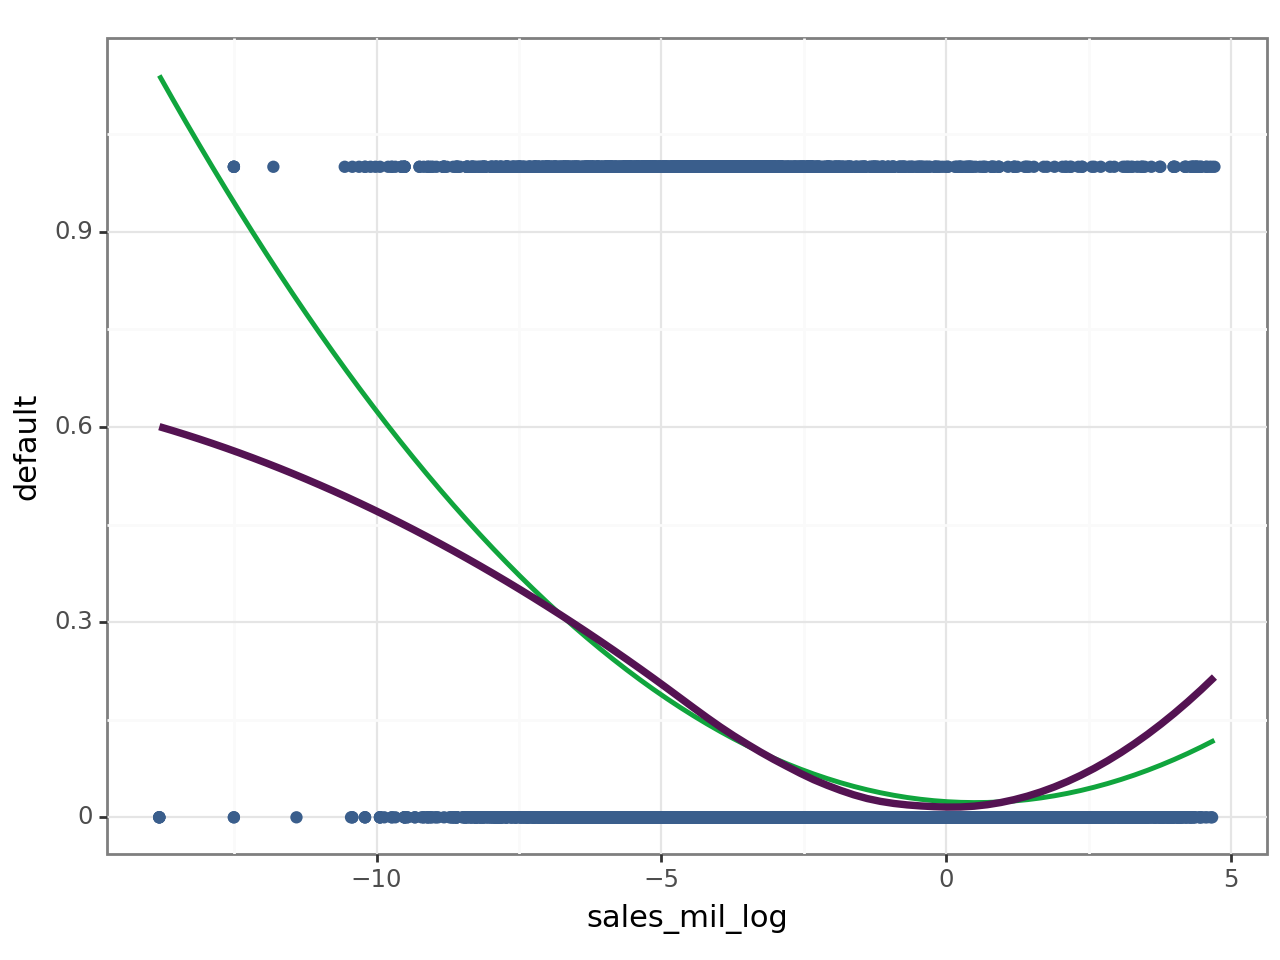

<Figure Size: (640 x 480)>

In [607]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)

In [608]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     757.5
Date:                Thu, 22 Feb 2024   Prob (F-statistic):          5.15e-314
Time:                        16:04:24   Log-Likelihood:                -1923.7
No. Observations:               14877   AIC:                             3853.
Df Residuals:                   14874   BIC:                             3876.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0241      0.003  

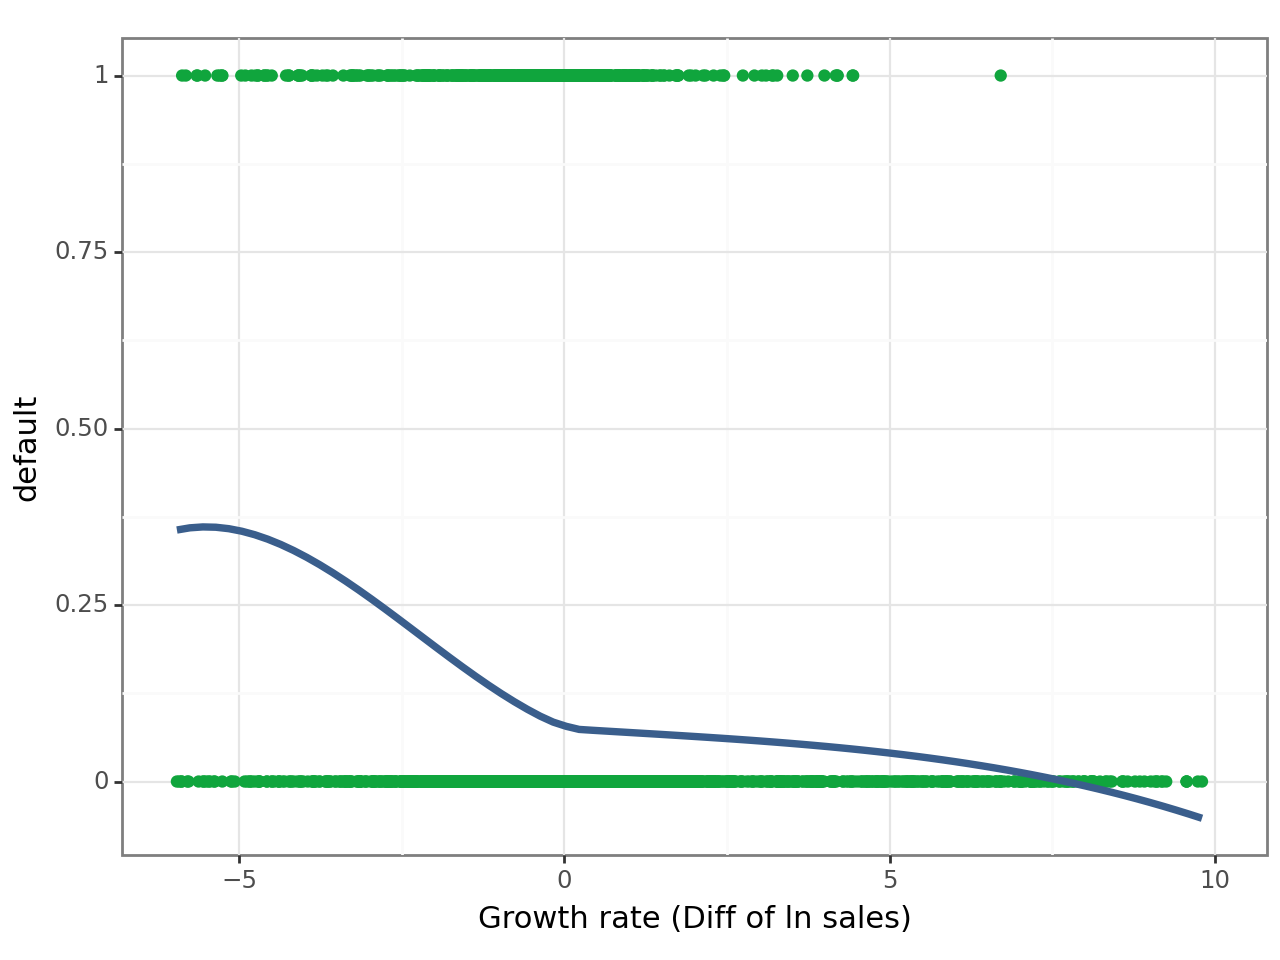

<Figure Size: (640 x 480)>

In [609]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

In [610]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [611]:
# no more imputation, drop obs if key vars missing
# data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

# ha ezt belerakjuk akkor elcsúszik a holdout set megvizsgáltam úgy hogy előtte beillesztettem a holdout set-es részt és utána is

In [612]:
# drop missing
# data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
# data["age"].describe()

# ha ezt belerakjuk akkor elcsúszik a holdout set megvizsgáltam úgy hogy előtte beillesztettem a holdout set-es részt és utána is


In [613]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

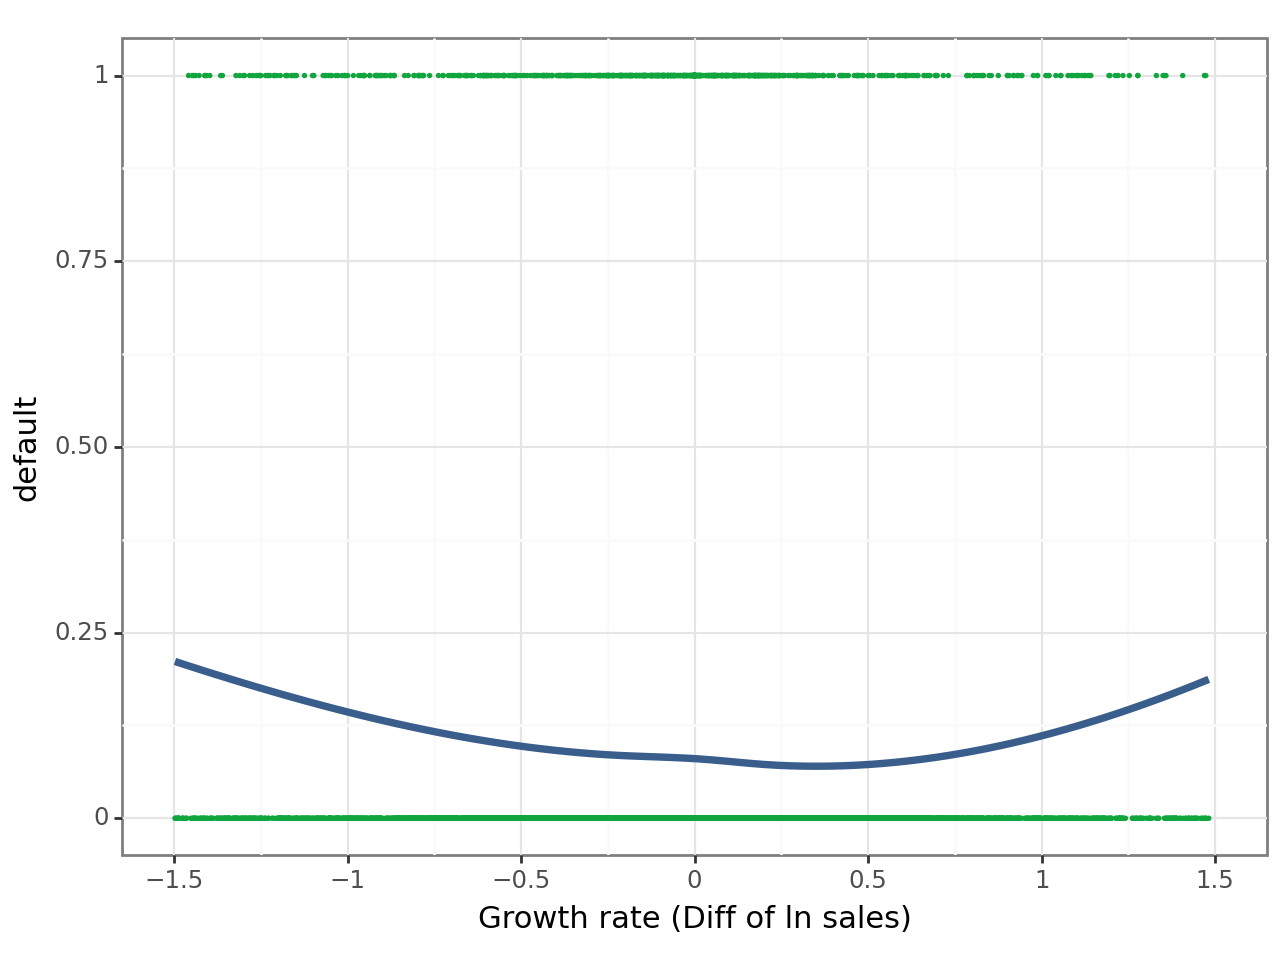

<Figure Size: (640 x 480)>

In [614]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)

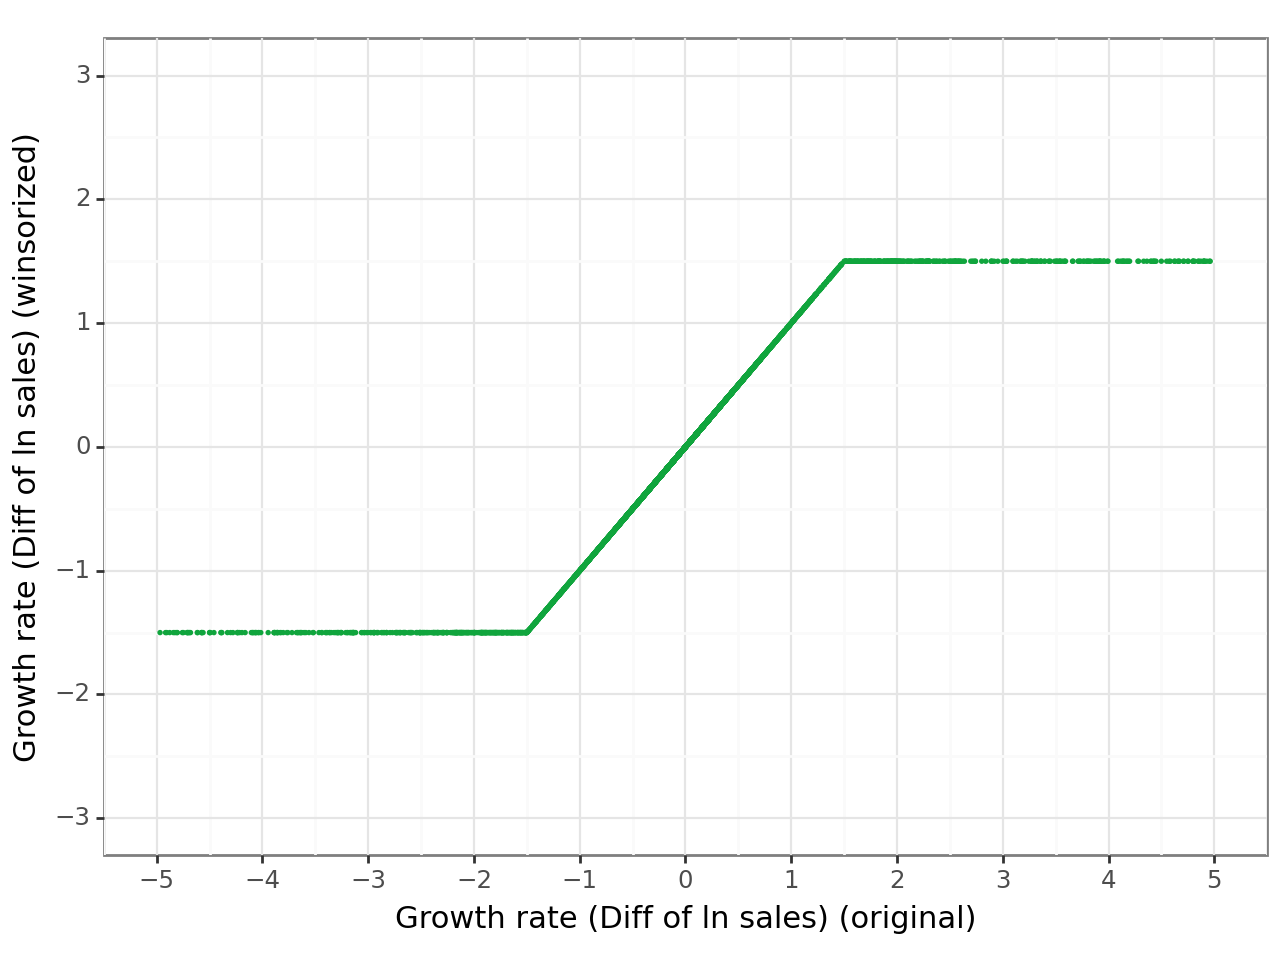

<Figure Size: (640 x 480)>

In [615]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [616]:
# look at firms below 10m euro revenues and above 1000 euros (SME filtering)
#data = data.loc[(data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# EDA

In [617]:
data[['year','comp_id']].groupby('year').nunique()

,comp_id
year,
2005,1829
2006,1829
2007,1829
2008,1829
2009,1829
2010,1829
2011,1829
2012,1829
2013,1829


In [618]:
data[['year','default','status_alive']].groupby('year').sum()

,default,status_alive
year,,
2005,77.0,1040.0
2006,67.0,1079.0
2007,79.0,1134.0
2008,76.0,1194.0
2009,102.0,1230.0
2010,101.0,1201.0
2011,77.0,1181.0
2012,91.0,1172.0
2013,79.0,1146.0


<Axes: xlabel='year'>

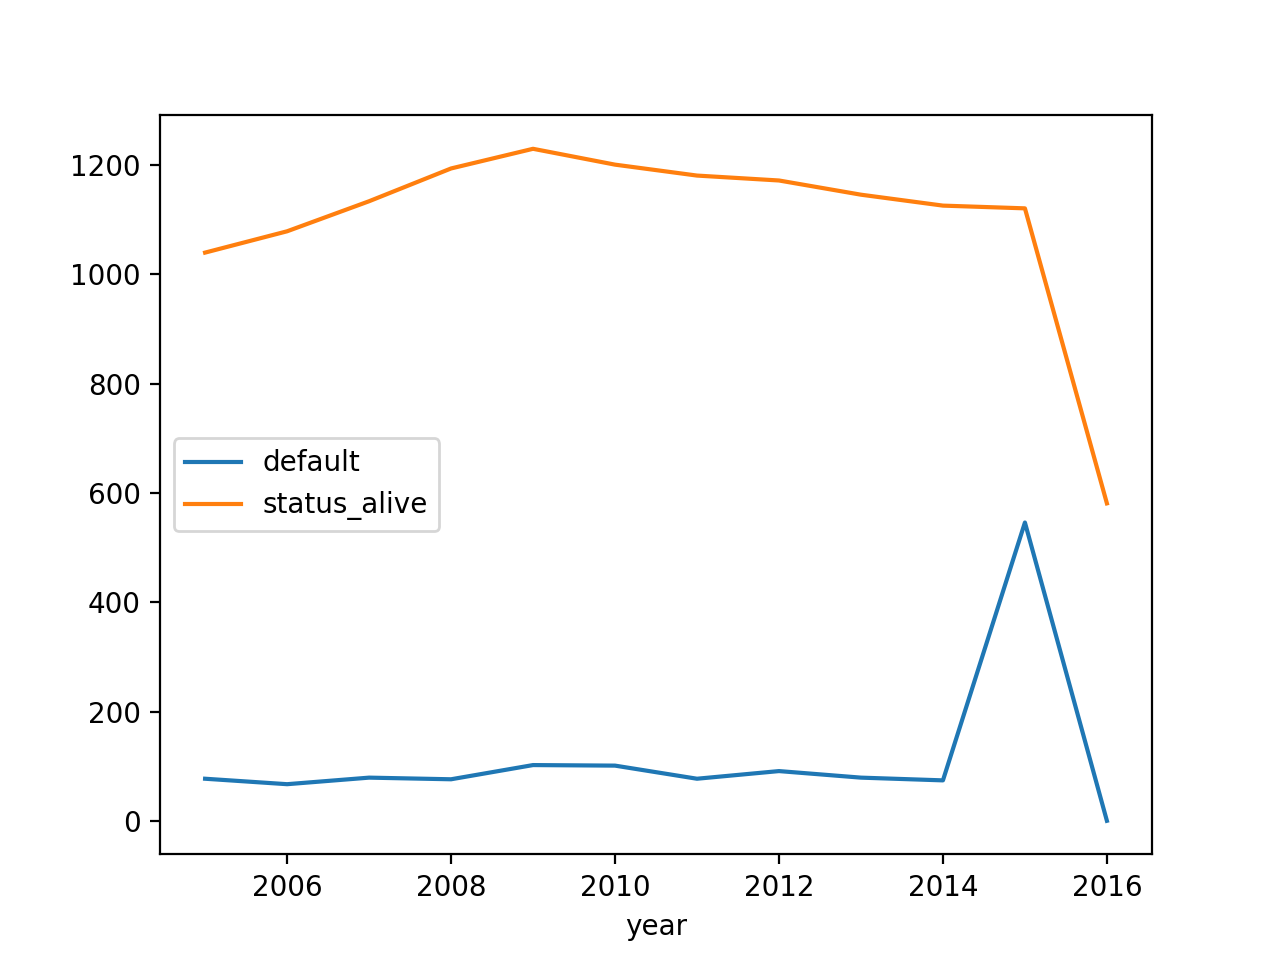

In [619]:
data[['year','default','status_alive']].groupby('year').sum().plot(kind='line')

In [620]:
data.default.mean()

0.09202124084156751

# Construction of the holdout set

We are only interested in predicting default for ‘ind2 == 26’, which is the selected industry, and the
firm is a small or medium enterprise (SME). Thus, yearly sales in 2014 was between 1000 EUR and 10
million EUR.

Existed in 2014 (sales > 0), but did not exists in 2015 (sales is 0 or missing)

If you do the sample design properly:
- you have an overall of 1037 firms.
- 56 firms defaulted
- 981 stayed alive. 
- The average sales of the firms is 0.4902 million EUR, with the minimum of 0.00107 million
EUR and 9.57648 million EUR.

In [621]:
# Creating the holdout set
holdout_set = data.loc[(data['year'] == 2014) & (data['sales'] >= 1000) & (data['sales'] <= 10000000)]

# Display information about the resulting holdout set
print("Total firms in holdout set:", len(holdout_set))
print("Number of defaulted firms:", len(holdout_set[holdout_set['default'] == 1]))
print("Number of firms that stayed alive:", len(holdout_set[holdout_set['default'] == 0]))  # Since all firms meet the condition
print("Average sales of the firms:", holdout_set['sales'].mean())
print("Minimum sales:", holdout_set['sales'].min())
print("Maximum sales:", holdout_set['sales'].max())

Total firms in holdout set: 1037
Number of defaulted firms: 56
Number of firms that stayed alive: 981
Average sales of the firms: 490202.21792682
Minimum sales: 1070.370361328125
Maximum sales: 9576485.0



# Kérdések
- jó e az a szűrés hogy ind2 csak 26, nem lehet se empty se semmi más
- 1 évet nézünk vagy többet?
    - ha többet nézünk akkor rakhatnánk bele olyan változókat amik valamiféle trendeket, változásokat vagy több éven keresztüli átlagokat mutatnak

- SME sales-t vizsgálni
- CEU age 75? sokallom
    - itt olyan gondolatom van hogy majd a modellek fine tuneolálásnál az ilyen apró dolgok megváltoztatásával tudjuk egyedivé tenni a modellt
